# Recurrent Neural Network (RNN) LSTM based Sentiment Analysis

In this we use LSTM (Long Short Term Memory) perceptron and use a neural network model to model sentiments based on inout word tokens and bigrams

In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('pymodules')

# Gensim
from gensim.models import Word2Vec
# making the plot look good ...
from adjustText import adjust_text
from sklearn.decomposition import PCA

from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
from tensorflow.keras.layers import Dropout

from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn import metrics
from sklearn.model_selection import train_test_split, ParameterGrid

# this class read the raw input and tokenizes comprehensively for use with modeling
import pymodules.read_and_tokenize as contacts_utils

from timeit import default_timer as timer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/Users/bmukund/miniconda3/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


### Read file and preprocess to generate tokens

In [2]:
filename = "data/Master-data_Q42021.xlsx"
prep_comments, df = contacts_utils.read_file(filename)

Read sheet 'Scrubbed_data' ...
Columns:Index(['TITLE', 'COMMENTS', 'OVERALL_RATING', 'COMFORT_RATING',
       'VISION_RATING', 'VALUE_FOR_MONEY', 'AUTHOR', 'PROS', 'CONS',
       'ORIGINAL_SOURCE', 'REPLY_FROM_ACCUVUE', 'FINAL_PRODUCT_NAME',
       'PRODUCT_LINK', 'WEBSITE', 'RATING', 'PRODUCT', 'BRAND'],
      dtype='object')
Columns dropped: ['OVERALL_RATING', 'COMFORT_RATING', 'VISION_RATING', 'VALUE_FOR_MONEY', 'PROS', 'CONS', 'ORIGINAL_SOURCE', 'REPLY_FROM_ACCUVUE', 'PRODUCT_LINK', 'WEBSITE']
 Drop the Author column and replace it with gender of author ...
Consolidate all the comments into one column called COMMENT
Make ratings into integers
Tokenize data based on regex found from experimentation and common usage ...
Comments before tokenization at index[0]:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!
Comments after tokenization at index

### Determine response variable called 'SENTIMENT' based on rating

* If Rating is < 3, we give a sentiment value of 0 (Negative sentiment)

* If Rating is = 3, we give a sentiment value of 1 (Neutral sentiment)

* If Rating is > 3, we give a sentiment value of 2 (Positive sentiment)

In [3]:
# attach sentiment, seems
def find_sentiment(rating):
    choices = [0, 1, 2]
    conditions = [rating < 3, rating == 3, rating > 3]
    senti = np.select(conditions, choices)
    return senti

df['SENTIMENT'] = df['RATING'].apply(find_sentiment).astype('category')

### Add bigrams to the word tokens so that sentiments are expressed better by word tokens and word-pairs

In [4]:
require_bigrams = True
if require_bigrams:
    for i in range(len(prep_comments.tokens)):
        prep_comments.tokens[i] = prep_comments.tokens[i] + prep_comments.bigrams[i]

test_index = 0
print(f"Comments at index[{test_index}] after addition of bigrams:\n {prep_comments.tokens[test_index]}")
print(f"Comments at index[{-1}] after addition of bigrams:\n {prep_comments.tokens[-1]}")

Comments at index[0] after addition of bigrams:
 ['used', 'for', 'long', 'time', 'and', 'say', 'service', 'from', 'com', 'great', 'and', 'work', 'great', 'for', 'needs', 'highly', 'recommend', 'used-for', 'for-long', 'long-time', 'time-and', 'and-say', 'say-service', 'service-from', 'from-com', 'com-great', 'great-and', 'and-work', 'work-great', 'great-for', 'for-needs', 'needs-highly', 'highly-recommend']
Comments at index[-1] after addition of bigrams:
 ['buy', 'again', 'order', 'came', 'fast', 'without', 'any', 'issues', 'and', 'candy', 'nice', 'touch', 'buy-again', 'again-order', 'order-came', 'came-fast', 'fast-without', 'without-any', 'any-issues', 'issues-and', 'and-candy', 'candy-nice', 'nice-touch']


In [5]:
## Create Dictionary
#id2word = corpora.Dictionary(prep_comments.tokens)
## Create Corpus: Term Document Frequency
#corpus = [id2word.doc2bow(text) for text in prep_comments.tokens]
#print(corpus)

### Add the token and Sentiments are new columns and display them

In [6]:
df['TOKENS'] = prep_comments.tokens

In [7]:
dfXY = df[['TOKENS', 'SENTIMENT']]

In [8]:
dfXY

,TOKENS,SENTIMENT
REVIEW_DATE,,
2021-11-01,"[used, for, long, time, and, say, service, fro...",2
2021-12-02,"[clear, vision, tends, cloud, clear-vision, vi...",2
2021-12-01,"[comfort, very, hard, handle, flimsy, but, com...",2
2021-11-16,"[easy, use, using, product, for, and, very, re...",2
2021-12-08,"[excellent, excellent, got, promised, discount...",2
...,...,...
2021-11-29,"[truly, best, price, fast, shipping, quick, ve...",2
2021-11-23,"[very, comfortable, vita, very, comfortable, a...",2
2021-12-27,"[very, comfortable, and, convenient, very, com...",2


### Showcase the imbalanced nature of Sentiments in the given data

[[Text(0, 0, '>3'), Text(1, 0, '<3'), Text(2, 0, '=3')]]

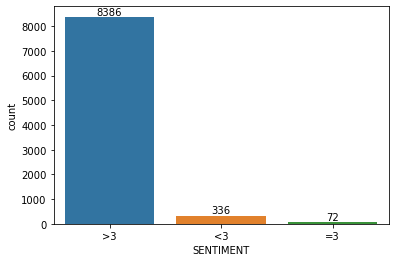

In [9]:
import seaborn as sns
ax = sns.countplot(x=dfXY['SENTIMENT'], order=dfXY['SENTIMENT'].value_counts(ascending=False).index)
abs_values = dfXY['SENTIMENT'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set(xticklabels=['>3', '<3', '=3'])

### Highly imbalanced data
* Because of highly imbalanced data, we need to "balance" by using class weights while fitting any model

## Use Keras engine for tokenization and also for RNN

### Take tokenized sentences and make it all integers using keras tokenizer on already tokenized data

In [10]:
# because embedding is independent of tokenization, we integerize our token based on keras tokenizer
num_expected_unique_words = 10000
keras_tokenizer = Tokenizer(num_expected_unique_words, split=",")
keras_tokenizer.fit_on_texts(dfXY['TOKENS'])

### Test, train, validation split

In [11]:
validation_reqd = True
X = dfXY.TOKENS
y = dfXY.SENTIMENT
df_trainX, df_trainy, df_testX, df_testy, df_validX, df_validy = contacts_utils.split_data(X, y, validation_reqd)

### Prepare data for input to RNN
* We pad the data so that the sequence length that goes into RNN is always the same (Usually this is not the case), which is set to 300
    * This sequence length is arbitrary and can be parameterized

In [12]:
MAX_SEQ_LEN = 300
X_train=keras_tokenizer.texts_to_sequences(df_trainX) # this converts texts into some numeric sequences
X_train_pad=pad_sequences(X_train,maxlen=MAX_SEQ_LEN,padding='post') # this makes the length of all numeric sequences equal

X_test = keras_tokenizer.texts_to_sequences(df_testX)
X_test_pad = pad_sequences(X_test, maxlen = MAX_SEQ_LEN, padding = 'post')

if validation_reqd:
    X_val = keras_tokenizer.texts_to_sequences(df_validX)
    X_val_pad = pad_sequences(X_val, maxlen = MAX_SEQ_LEN, padding = 'post')
else:
    X_val = None
    X_val_pad = None

In [13]:
y_train = to_categorical(df_trainy.values,num_classes=3)
y_test = to_categorical(df_testy.values, num_classes=3)
if validation_reqd:
    y_val = to_categorical(df_validy.values, num_classes=3)
else:
    y_val = None

### Balance imbalanced data using class weights 
Compute sentiment class weights based on training data to balance the dataset

In [14]:
from sklearn.utils.class_weight import compute_class_weight
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
sentiment_class_weights = dict(enumerate(class_weights))

{0: 7.460030165912519, 1: 34.34722222222222, 2: 0.3525051671299266}


/Users/bmukund/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


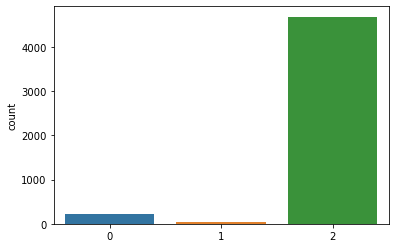

[ 221   48 4677]


/Users/bmukund/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


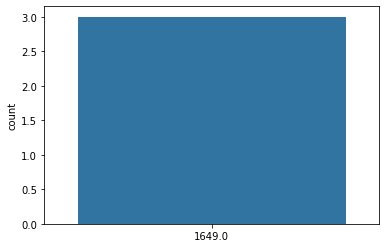

In [15]:
### Test if balancing has indeed taken place ...
print(sentiment_class_weights)
sns.countplot(y_integers)
plt.show()
print(np.bincount(y_integers))
balance_wts = np.array([val for k, val in sentiment_class_weights.items()])
bal = np.round(np.bincount(y_integers) * balance_wts)
sns.countplot(bal)
plt.show()

### Train gensim model to generate word embeddings made of 100 dimensional vector
* Word embeddings vector is of size 100
* It is based on universal dictionary
* Each word/token now is expressed as a vector of 100 arbitrary, deterministic features. i.e. a word is embedded in a $R^{100}$ basis space

In [16]:
# train Gensim's Word2Vec model
gensim_model = Word2Vec(sentences=prep_comments.tokens,      # corpus
                        vector_size=100,            # embedding dimension
                        window=4,                   # words before and after to take into consideration
                        sg=1,                       # use skip-gram
                        negative=5,                 # number of negative examples for each positive one
                        alpha=0.025,                # initial learning rate
                        min_alpha=0.0001,           # minimum learning rate
                        epochs=10,                   # number of passes through the data
                        min_count=1,                # words that appear less than this are removed
                        workers=4,                  # we use 1 to ensure replicability
                        seed=92                     # for replicability
                        )

### Do some gensim validation to ensure that word embeddings have been generated

In [17]:
# extract the word embeddings from the model
word_vectors = gensim_model.wv
word_vectors.vectors.shape  # vocab_size x embeddings dimension

(33417, 100)

In [18]:
word_vectors_weights = gensim_model.wv.vectors
vocab_size, embedding_size = word_vectors_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 33417 - Embedding Dim: 100


In [19]:
# Some validation on the quality of the Word2Vec model
print(gensim_model.wv.most_similar('product', topn=3))
print(gensim_model.wv.most_similar('price', topn=3))
print(gensim_model.wv.most_similar('service', topn=3))
print(gensim_model.wv.most_similar('quality', topn=3))
print(gensim_model.wv.most_similar(positive=['comfort', 'fit'], negative=['dry'], topn=3))

def word2token(word):
    try:
        return gensim_model.wv.key_to_index[word]
    except KeyError:
        return 0

def token2word(token):
    return gensim_model.wv.index_to_key[token]

[('complaints', 0.8658158183097839), ('usual', 0.8622128367424011), ('overall', 0.8606114387512207)]
[('reasonable', 0.8719999194145203), ('appropriate', 0.8672037720680237), ('overall', 0.8653236031532288)]
[('prompt', 0.9291145205497742), ('support', 0.9211879372596741), ('code', 0.9158746600151062)]
[('inexpensive', 0.9033172130584717), ('high', 0.8809385895729065), ('value', 0.8762818574905396)]
[('and-comfort', 0.780631959438324), ('comfort-clarity', 0.7758169174194336), ('comfort-and', 0.7712889909744263)]


In [20]:
gensim_weight_matrix = np.zeros((num_expected_unique_words ,embedding_size))
gensim_weight_matrix.shape

(10000, 100)

### Encode word embeddings
* Test key to index for word vectors, so we can go back and forth between word and its embedding

In [21]:
word_vectors[word_vectors.key_to_index['dry']]

array([-0.97792184,  0.6101492 , -0.1633291 ,  0.95594984, -0.69298893,
        0.05233026, -0.2186156 ,  0.36031935, -0.07722113,  0.012258  ,
        0.74179685,  0.47341073, -0.1044374 , -0.30277476, -0.56844264,
       -0.5310976 , -0.3110355 , -0.11101796,  0.29717454, -1.0855538 ,
        0.95120025, -0.2957213 , -0.09312268,  0.425216  ,  0.03509908,
        0.06711707,  0.23925464,  0.0388074 ,  0.19528106,  0.42602095,
        0.47665733,  0.78954566, -0.55358446,  0.19194633,  0.36639485,
        0.5742307 ,  0.5829207 ,  0.16552289,  0.75133175, -0.73686993,
        0.41969606, -0.19961365, -0.38251752,  0.17161398,  0.07439642,
        0.5538888 ,  0.31072697,  0.52557015, -0.06848207, -0.24707793,
        1.2307658 ,  0.05478761,  0.11644079, -0.10247983, -0.7407401 ,
       -0.20715386, -0.19503647,  1.0609044 ,  0.7509476 , -0.52510244,
       -0.90642005,  1.7055451 , -0.03284806,  0.8514643 ,  0.2591121 ,
       -0.2828203 ,  0.39864686, -1.3440636 , -0.04130106, -0.74

### Map the index of the word (obtained by keras_tokenizer, which assigned interger values to words) to its weight matrix obtained from word embedding

In [22]:
for word, index in keras_tokenizer.word_index.items():
    if index < num_expected_unique_words: # why ? since index starts with zero
        try:
            word_index_in_embedding = word_vectors.key_to_index[word]
        except KeyError:
            gensim_weight_matrix[index] = np.zeros(embedding_size)
        else:
            gensim_weight_matrix[index] = word_vectors[word_index_in_embedding]

In [23]:
gensim_weight_matrix.shape

(10000, 100)

### RNN model

In [24]:
num_sentiments  = 3

### Cache results of RNN model in sentiment_RNN_Model.h5

In [25]:
#EarlyStopping and ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./sentiment_RNN_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

### The RNN model

* 3 hidden layers

* loss function is "categorical cross entropy" as the sentiments are categorical

In [26]:
def create_RNN_model(num_sentiments, sentiment_class_weights, num_expected_unique_words, embedding_size, gensim_weight_matrix, trainX, trainy, validX, validy, testX, testy):
    def _create_RNN_model(param_dict):
        _epochs = param_dict['epochs']
        _batch_size = param_dict['batch_size']
        drop_out_factor = param_dict['drop_out_factor']
        lstm_nodes = param_dict['lstm_nodes']

        # fixed three layers ...
        model = Sequential()
        model.add(Embedding(input_dim = num_expected_unique_words,
                    output_dim = embedding_size,
                    input_length= trainX.shape[1],
                    weights = [gensim_weight_matrix],
                    trainable = False))

        model.add(Dropout(drop_out_factor[0]))
        model.add(Bidirectional(LSTM(lstm_nodes[0],return_sequences=True)))
        model.add(Dropout(drop_out_factor[1]))
        model.add(Bidirectional(LSTM(lstm_nodes[1],return_sequences=True)))
        model.add(Dropout(drop_out_factor[2]))
        model.add(Bidirectional(LSTM(lstm_nodes[2],return_sequences=False)))

        model.add(Dense(num_sentiments, activation = 'softmax'))

        model.compile(loss = 'categorical_crossentropy',
                      optimizer = 'adam',
                      metrics = 'accuracy')

        history = model.fit(trainX, trainy,
                            epochs = _epochs,
                            batch_size = _batch_size,
                            validation_data=(validX, validy),
                            verbose = 1,
                            #callbacks= [es, mc],
                            class_weight = sentiment_class_weights,
                            workers=4,
                            use_multiprocessing=True)

        _, test_score = model.evaluate(testX,testy)
        y_pred_test_raw = model.predict(testX, workers=4, use_multiprocessing=True)
        y_test_pred = np.argmax(y_pred_test_raw, axis = 1)
        return test_score, param_dict, history, y_test_pred, model

    return _create_RNN_model

### Model parameterization

In [27]:
# parameters to be varied
batch_size = [100, 300]
epochs = [50, 100]
drop_out_factor = [[0.1, 0.1, 0.1], [0.2, 0.2, 0.2]]
lstm_nodes = [[100, 200, 100], [50, 100, 50]]

parameters = [{'epochs': epochs,
               'batch_size': batch_size,
               'drop_out_factor':drop_out_factor,
               'lstm_nodes':lstm_nodes
               }
              ]

# make a grid out of parameter choices ...
grid_params = ParameterGrid(parameters)
#for x in grid_params:
#    print(f"===== Params ===== \n {x}")

### Run different models with different parameterizations to choose the best mode
* Best model is chosen based on accuracy of  validation scores

In [28]:
# func that sets up the context .. i.e. what the pipeline does, what the data input is
RNN_model_func = create_RNN_model(num_sentiments, sentiment_class_weights, num_expected_unique_words,
                                  embedding_size, gensim_weight_matrix,
                                  X_train_pad, y_train, X_val_pad, y_val, X_test_pad, y_test)

st_ = timer()
# run NN model in parallel and extract results (train_score, valid_score,parameter, history of fit) as a list
results = contacts_utils.run_parallel(RNN_model_func, num_cpus=4)(grid_params)

end_ = timer()

print(f"Time taken to finish best parameter search with RNN model: {(end_-st_)/60.0} mins.")

2022-08-08 18:04:05.623272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-08 18:04:05.692980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-08 18:04:05.762476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

Epoch 1/50
Epoch 1/50
Epoch 1/100
Epoch 1/100
50/50 [==============================] - 190s 4s/step - loss: 1.0485 - accuracy: 0.5888 - val_loss: 1.1604 - val_accuracy: 0.5609
Epoch 2/100
50/50 [==============================] - 190s 4s/step - loss: 1.0453 - accuracy: 0.5198 - val_loss: 1.1489 - val_accuracy: 0.6222
Epoch 2/50
50/50 [==============================] - 163s 3s/step - loss: 0.9654 - accuracy: 0.7254 - val_loss: 0.9830 - val_accuracy: 0.5719
Epoch 3/50
50/50 [==============================] - 166s 3s/step - loss: 0.9567 - accuracy: 0.6735 - val_loss: 0.8768 - val_accuracy: 0.7229
Epoch 3/100
50/50 [==============================] - 357s 7s/step - loss: 1.0497 - accuracy: 0.5479 - val_loss: 1.1977 - val_accuracy: 0.4579
Epoch 2/50
50/50 [==============================] - 360s 7s/step - loss: 1.0447 - accuracy: 0.5334 - val_loss: 1.0471 - val_accuracy: 0.5973
Epoch 2/100
50/50 [==============================] - 186s 4s/step - loss: 0.9233 - accuracy: 0.6856 - val_loss: 0.601

50/50 [==============================] - 2409s 49s/step - loss: 0.6794 - accuracy: 0.7499 - val_loss: 0.6248 - val_accuracy: 0.7884
Epoch 21/100
50/50 [==============================] - 3059s 62s/step - loss: 0.8038 - accuracy: 0.7572 - val_loss: 0.8042 - val_accuracy: 0.6925
Epoch 11/50
50/50 [==============================] - 3064s 62s/step - loss: 0.8843 - accuracy: 0.6664 - val_loss: 0.8411 - val_accuracy: 0.6452
Epoch 11/100
50/50 [==============================] - 2401s 49s/step - loss: 0.6700 - accuracy: 0.6779 - val_loss: 1.0360 - val_accuracy: 0.4651
Epoch 22/50
50/50 [==============================] - 657s 13s/step - loss: 0.6787 - accuracy: 0.6864 - val_loss: 0.5388 - val_accuracy: 0.8090
Epoch 22/100
50/50 [==============================] - 653s 13s/step - loss: 0.6324 - accuracy: 0.7483 - val_loss: 0.6412 - val_accuracy: 0.7532
Epoch 23/50
50/50 [==============================] - 645s 13s/step - loss: 0.7106 - accuracy: 0.7505 - val_loss: 0.8385 - val_accuracy: 0.6768
Epoc

50/50 [==============================] - 651s 13s/step - loss: 0.4085 - accuracy: 0.7159 - val_loss: 0.5528 - val_accuracy: 0.7544
Epoch 40/50
50/50 [==============================] - 659s 13s/step - loss: 0.4706 - accuracy: 0.7384 - val_loss: 0.5939 - val_accuracy: 0.7119
Epoch 40/100
50/50 [==============================] - 652s 13s/step - loss: 0.4730 - accuracy: 0.7574 - val_loss: 0.6544 - val_accuracy: 0.7356
Epoch 41/50
50/50 [==============================] - 654s 13s/step - loss: 0.5188 - accuracy: 0.7020 - val_loss: 0.7016 - val_accuracy: 0.6853
Epoch 41/100
50/50 [==============================] - 1318s 26s/step - loss: 0.6894 - accuracy: 0.7256 - val_loss: 0.5720 - val_accuracy: 0.7550
Epoch 21/50
50/50 [==============================] - 1318s 26s/step - loss: 0.7672 - accuracy: 0.7139 - val_loss: 0.6789 - val_accuracy: 0.7404
Epoch 21/100
50/50 [==============================] - 1820s 37s/step - loss: 0.4880 - accuracy: 0.7465 - val_loss: 0.5230 - val_accuracy: 0.7635
Epoch

50/50 [==============================] - 514s 10s/step - loss: 0.3676 - accuracy: 0.7630 - val_loss: 0.6462 - val_accuracy: 0.7659
Epoch 53/100
50/50 [==============================] - 1973s 40s/step - loss: 0.4870 - accuracy: 0.7699 - val_loss: 0.6660 - val_accuracy: 0.6950
Epoch 27/50
50/50 [==============================] - 1971s 40s/step - loss: 0.7187 - accuracy: 0.6996 - val_loss: 0.9039 - val_accuracy: 0.5828
Epoch 27/100
 1/50 [..............................] - ETA: 15:53 - loss: 0.4817 - accuracy: 0.5900INFO:tensorflow:Assets written to: ram://8e359d43-c701-4618-8a38-177c621e4086/assets


INFO:tensorflow:Assets written to: ram://8e359d43-c701-4618-8a38-177c621e4086/assets


 4/50 [=>............................] - ETA: 15:46 - loss: 0.6868 - accuracy: 0.7325

2022-08-09 04:35:51.290178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


50/50 [==============================] - 540s 11s/step - loss: 0.4486 - accuracy: 0.7845 - val_loss: 0.4783 - val_accuracy: 0.7762
Epoch 54/100
50/50 [==============================] - 648s 13s/step - loss: 0.3060 - accuracy: 0.7934 - val_loss: 0.5407 - val_accuracy: 0.7556
Epoch 55/100
50/50 [==============================] - 1205s 24s/step - loss: 0.5009 - accuracy: 0.7558 - val_loss: 0.8845 - val_accuracy: 0.5894
Epoch 28/50
50/50 [==============================] - 1210s 24s/step - loss: 0.6687 - accuracy: 0.6577 - val_loss: 0.5888 - val_accuracy: 0.7920
Epoch 28/100
50/50 [==============================] - 618s 12s/step - loss: 0.2646 - accuracy: 0.8195 - val_loss: 0.4630 - val_accuracy: 0.7968
Epoch 56/100
50/50 [==============================] - 1752s 29s/step - loss: 1.0581 - accuracy: 0.5999 - val_loss: 1.2909 - val_accuracy: 0.5603
Epoch 2/50
50/50 [==============================] - 648s 13s/step - loss: 0.2464 - accuracy: 0.8239 - val_loss: 0.4799 - val_accuracy: 0.7908
Epoch

50/50 [==============================] - 196s 4s/step - loss: 0.1757 - accuracy: 0.8674 - val_loss: 0.3588 - val_accuracy: 0.8466
Epoch 77/100
50/50 [==============================] - 391s 8s/step - loss: 0.3529 - accuracy: 0.7986 - val_loss: 0.5873 - val_accuracy: 0.7332
Epoch 39/50
50/50 [==============================] - 394s 8s/step - loss: 0.6483 - accuracy: 0.6731 - val_loss: 0.8137 - val_accuracy: 0.6562
Epoch 39/100
50/50 [==============================] - 197s 4s/step - loss: 0.1683 - accuracy: 0.8771 - val_loss: 0.4540 - val_accuracy: 0.8035
Epoch 78/100
50/50 [==============================] - 392s 8s/step - loss: 0.8426 - accuracy: 0.5894 - val_loss: 0.4766 - val_accuracy: 0.8205
Epoch 13/50
50/50 [==============================] - 180s 4s/step - loss: 0.1628 - accuracy: 0.8854 - val_loss: 0.3823 - val_accuracy: 0.8417
Epoch 79/100
50/50 [==============================] - 375s 7s/step - loss: 0.2914 - accuracy: 0.7768 - val_loss: 0.4893 - val_accuracy: 0.7817
Epoch 40/50
50

50/50 [==============================] - 191s 4s/step - loss: 0.1382 - accuracy: 0.8953 - val_loss: 0.2909 - val_accuracy: 0.8945
Epoch 99/100
50/50 [==============================] - 383s 8s/step - loss: 0.6896 - accuracy: 0.6994 - val_loss: 0.5326 - val_accuracy: 0.7968
Epoch 24/50
50/50 [==============================] - 191s 4s/step - loss: 0.1312 - accuracy: 0.9131 - val_loss: 0.3154 - val_accuracy: 0.8890
Epoch 100/100
50/50 [==============================] - 378s 8s/step - loss: 0.5106 - accuracy: 0.7165 - val_loss: 0.6704 - val_accuracy: 0.7210
Epoch 51/100
50/50 [==============================] - 342s 7s/step - loss: 0.6686 - accuracy: 0.6905 - val_loss: 0.7753 - val_accuracy: 0.6349
Epoch 25/50
21/50 [===========>..................] - ETA: 2:04 - loss: 0.6496 - accuracy: 0.6890

24/50 [=============>................] - ETA: 1:50 - loss: 0.6198 - accuracy: 0.6862

26/50 [==============>...............] - ETA: 1:40 - loss: 0.6144 - accuracy: 0.6885INFO:tensorflow:Assets written to: ram://71f87545-4633-4de2-8aeb-f8940433034c/assets


INFO:tensorflow:Assets written to: ram://71f87545-4633-4de2-8aeb-f8940433034c/assets


50/50 [==============================] - 263s 5s/step - loss: 0.3561 - accuracy: 0.8013 - val_loss: 0.5585 - val_accuracy: 0.7253
Epoch 52/100
Epoch 1/50
 2/50 [>.............................] - ETA: 3:16 - loss: 0.3865 - accuracy: 0.7200INFO:tensorflow:Assets written to: ram://80d5ab45-9bd1-49d7-b186-3851a1f7ae1e/assets


INFO:tensorflow:Assets written to: ram://80d5ab45-9bd1-49d7-b186-3851a1f7ae1e/assets


50/50 [==============================] - 244s 5s/step - loss: 0.6146 - accuracy: 0.7208 - val_loss: 0.7538 - val_accuracy: 0.6537
Epoch 26/50
50/50 [==============================] - 247s 4s/step - loss: 1.0505 - accuracy: 0.5657 - val_loss: 0.8621 - val_accuracy: 0.7526
Epoch 2/50
50/50 [==============================] - 283s 6s/step - loss: 0.3292 - accuracy: 0.7938 - val_loss: 0.5435 - val_accuracy: 0.7489
Epoch 53/100
50/50 [==============================] - 183s 4s/step - loss: 1.0064 - accuracy: 0.6876 - val_loss: 1.0993 - val_accuracy: 0.6064
Epoch 3/50
50/50 [==============================] - 331s 7s/step - loss: 0.5797 - accuracy: 0.7091 - val_loss: 0.6585 - val_accuracy: 0.7477
Epoch 27/50
50/50 [==============================] - 161s 3s/step - loss: 0.9881 - accuracy: 0.6448 - val_loss: 0.7460 - val_accuracy: 0.7301
Epoch 4/50
50/50 [==============================] - 343s 7s/step - loss: 0.3396 - accuracy: 0.7675 - val_loss: 0.6286 - val_accuracy: 0.7314
Epoch 54/100
50/50 [

50/50 [==============================] - 392s 8s/step - loss: 0.8511 - accuracy: 0.7186 - val_loss: 0.5461 - val_accuracy: 0.8296
Epoch 12/100
50/50 [==============================] - 194s 4s/step - loss: 0.6799 - accuracy: 0.6969 - val_loss: 0.5203 - val_accuracy: 0.8338
Epoch 25/50
50/50 [==============================] - 388s 8s/step - loss: 0.4901 - accuracy: 0.7687 - val_loss: 0.6252 - val_accuracy: 0.7726
Epoch 38/50
50/50 [==============================] - 194s 4s/step - loss: 0.6958 - accuracy: 0.6929 - val_loss: 0.6102 - val_accuracy: 0.7477
Epoch 26/50
50/50 [==============================] - 386s 8s/step - loss: 0.2275 - accuracy: 0.8615 - val_loss: 0.5520 - val_accuracy: 0.7362
Epoch 65/100
50/50 [==============================] - 393s 8s/step - loss: 0.8579 - accuracy: 0.6793 - val_loss: 0.6959 - val_accuracy: 0.7435
Epoch 13/100
50/50 [==============================] - 194s 4s/step - loss: 0.6306 - accuracy: 0.7002 - val_loss: 0.6300 - val_accuracy: 0.7659
Epoch 27/50
50/

50/50 [==============================] - 283s 6s/step - loss: 0.4965 - accuracy: 0.7319 - val_loss: 0.7062 - val_accuracy: 0.6161
Epoch 47/50
50/50 [==============================] - 249s 5s/step - loss: 0.4397 - accuracy: 0.7525 - val_loss: 0.4595 - val_accuracy: 0.8011
Epoch 48/50
50/50 [==============================] - 538s 11s/step - loss: 0.1975 - accuracy: 0.8694 - val_loss: 0.6418 - val_accuracy: 0.7508
Epoch 76/100
50/50 [==============================] - 488s 10s/step - loss: 0.7114 - accuracy: 0.7374 - val_loss: 0.7413 - val_accuracy: 0.7271
Epoch 24/100
50/50 [==============================] - 454s 9s/step - loss: 0.4059 - accuracy: 0.6706 - val_loss: 0.3697 - val_accuracy: 0.8884
Epoch 50/50
50/50 [==============================] - 196s 4s/step - loss: 0.4631 - accuracy: 0.7180 - val_loss: 0.6270 - val_accuracy: 0.7077
Epoch 49/50
50/50 [==============================] - 194s 4s/step - loss: 0.5498 - accuracy: 0.7317 - val_loss: 0.5761 - val_accuracy: 0.7126
Epoch 50/50
50

50/50 [==============================] - 288s 6s/step - loss: 0.7855 - accuracy: 0.6405 - val_loss: 0.8803 - val_accuracy: 0.6604
Epoch 26/100
18/50 [=========>....................] - ETA: 2:14 - loss: 0.2044 - accuracy: 0.8561

19/50 [==========>...................] - ETA: 2:10 - loss: 0.1992 - accuracy: 0.8574INFO:tensorflow:Assets written to: ram://f627c652-80cc-4d49-a3f7-94f4c369cb0e/assets


INFO:tensorflow:Assets written to: ram://f627c652-80cc-4d49-a3f7-94f4c369cb0e/assets


23/50 [============>.................] - ETA: 1:55 - loss: 0.1977 - accuracy: 0.8570INFO:tensorflow:Assets written to: ram://45755105-e264-4221-9814-ce44b8814d50/assets


INFO:tensorflow:Assets written to: ram://45755105-e264-4221-9814-ce44b8814d50/assets


50/50 [==============================] - 261s 5s/step - loss: 0.2170 - accuracy: 0.8504 - val_loss: 0.4820 - val_accuracy: 0.8393
Epoch 79/100
50/50 [==============================] - 236s 3s/step - loss: 1.0672 - accuracy: 0.5190 - val_loss: 1.1043 - val_accuracy: 0.6216
Epoch 2/100
50/50 [==============================] - 310s 6s/step - loss: 0.7499 - accuracy: 0.7246 - val_loss: 0.5825 - val_accuracy: 0.7805
Epoch 27/100
50/50 [==============================] - 211s 4s/step - loss: 0.9991 - accuracy: 0.7022 - val_loss: 0.8347 - val_accuracy: 0.7532
Epoch 3/100
50/50 [==============================] - 388s 8s/step - loss: 0.2332 - accuracy: 0.8324 - val_loss: 0.5270 - val_accuracy: 0.8108
Epoch 80/100
17/17 [==============================] - 491s 21s/step - loss: 1.0866 - accuracy: 0.5435 - val_loss: 1.1479 - val_accuracy: 0.6343
Epoch 2/50
50/50 [==============================] - 191s 4s/step - loss: 0.9583 - accuracy: 0.6763 - val_loss: 0.7680 - val_accuracy: 0.7126
Epoch 4/100
50/

Epoch 90/100
17/17 [==============================] - 383s 23s/step - loss: 0.7563 - accuracy: 0.7123 - val_loss: 0.7880 - val_accuracy: 0.6653
Epoch 14/50
50/50 [==============================] - 384s 8s/step - loss: 0.6736 - accuracy: 0.7056 - val_loss: 0.6794 - val_accuracy: 0.7332
Epoch 24/100
50/50 [==============================] - 689s 14s/step - loss: 0.5972 - accuracy: 0.6994 - val_loss: 0.6812 - val_accuracy: 0.7332
Epoch 38/100
50/50 [==============================] - 370s 7s/step - loss: 0.6352 - accuracy: 0.7268 - val_loss: 0.6591 - val_accuracy: 0.7356
Epoch 25/100
17/17 [==============================] - 619s 36s/step - loss: 0.7504 - accuracy: 0.7260 - val_loss: 0.8610 - val_accuracy: 0.6719
Epoch 15/50
50/50 [==============================] - 717s 14s/step - loss: 0.7971 - accuracy: 0.6292 - val_loss: 1.0469 - val_accuracy: 0.5470
Epoch 91/100
50/50 [==============================] - 200s 4s/step - loss: 0.6525 - accuracy: 0.6688 - val_loss: 0.6793 - val_accuracy: 0.71

17/17 [==============================] - 286s 17s/step - loss: 0.5759 - accuracy: 0.6577 - val_loss: 0.5845 - val_accuracy: 0.7568
Epoch 28/50
50/50 [==============================] - 171s 3s/step - loss: 0.4286 - accuracy: 0.7523 - val_loss: 0.5174 - val_accuracy: 0.8169
Epoch 46/100
50/50 [==============================] - 347s 7s/step - loss: 0.4893 - accuracy: 0.7339 - val_loss: 0.5122 - val_accuracy: 0.7744
Epoch 49/100
50/50 [==============================] - 150s 3s/step - loss: 0.4431 - accuracy: 0.7580 - val_loss: 0.5896 - val_accuracy: 0.7411
Epoch 47/100
17/17 [==============================] - 232s 13s/step - loss: 0.4888 - accuracy: 0.8021 - val_loss: 0.5357 - val_accuracy: 0.7950
Epoch 29/50
42/50 [========================>.....] - ETA: 42s - loss: 0.4101 - accuracy: 0.7517

50/50 [==============================] - 145s 3s/step - loss: 0.3616 - accuracy: 0.7897 - val_loss: 0.6066 - val_accuracy: 0.7326
Epoch 48/100
16/50 [========>.....................] - ETA: 1:29 - loss: 0.4596 - accuracy: 0.7500INFO:tensorflow:Assets written to: ram://b51bc778-897a-4496-abfb-e5855fc78adb/assets


INFO:tensorflow:Assets written to: ram://b51bc778-897a-4496-abfb-e5855fc78adb/assets


50/50 [==============================] - 286s 6s/step - loss: 0.4198 - accuracy: 0.7582 - val_loss: 0.5651 - val_accuracy: 0.7817
Epoch 50/100
50/50 [==============================] - 147s 3s/step - loss: 0.4301 - accuracy: 0.7386 - val_loss: 0.3795 - val_accuracy: 0.8696
Epoch 49/100
17/17 [==============================] - 233s 14s/step - loss: 0.4858 - accuracy: 0.7331 - val_loss: 0.3916 - val_accuracy: 0.8830
Epoch 30/50
50/50 [==============================] - 183s 4s/step - loss: 0.3672 - accuracy: 0.7723 - val_loss: 0.6176 - val_accuracy: 0.7022
Epoch 50/100
17/17 [==============================] - 325s 14s/step - loss: 1.0614 - accuracy: 0.4931 - val_loss: 1.4022 - val_accuracy: 0.5039
Epoch 2/50
50/50 [==============================] - 333s 7s/step - loss: 0.4072 - accuracy: 0.7357 - val_loss: 0.5814 - val_accuracy: 0.7962
Epoch 51/100
17/17 [==============================] - 292s 17s/step - loss: 0.5707 - accuracy: 0.7778 - val_loss: 0.4926 - val_accuracy: 0.8120
Epoch 31/50


Epoch 40/50
17/17 [==============================] - 133s 8s/step - loss: 0.6642 - accuracy: 0.7315 - val_loss: 0.6297 - val_accuracy: 0.7617
Epoch 22/50
50/50 [==============================] - 174s 3s/step - loss: 0.3535 - accuracy: 0.7610 - val_loss: 0.5899 - val_accuracy: 0.7374
Epoch 66/100
17/17 [==============================] - 131s 8s/step - loss: 0.6504 - accuracy: 0.7550 - val_loss: 0.6490 - val_accuracy: 0.7599
Epoch 23/50
50/50 [==============================] - 348s 7s/step - loss: 0.3769 - accuracy: 0.7802 - val_loss: 0.4766 - val_accuracy: 0.8114
Epoch 59/100
50/50 [==============================] - 175s 3s/step - loss: 0.3075 - accuracy: 0.7560 - val_loss: 0.4996 - val_accuracy: 0.8351
Epoch 67/100
17/17 [==============================] - 280s 17s/step - loss: 0.4172 - accuracy: 0.7238 - val_loss: 0.5302 - val_accuracy: 0.7690
Epoch 41/50
17/17 [==============================] - 132s 8s/step - loss: 0.6859 - accuracy: 0.6622 - val_loss: 0.9240 - val_accuracy: 0.6258
Ep

17/17 [==============================] - 130s 8s/step - loss: 0.3683 - accuracy: 0.7875 - val_loss: 0.5058 - val_accuracy: 0.8193
Epoch 44/50
50/50 [==============================] - 342s 7s/step - loss: 0.3813 - accuracy: 0.7827 - val_loss: 0.6860 - val_accuracy: 0.6962
Epoch 67/100
17/17 [==============================] - 134s 8s/step - loss: 0.4322 - accuracy: 0.7626 - val_loss: 0.7029 - val_accuracy: 0.7168
Epoch 45/50
50/50 [==============================] - 173s 3s/step - loss: 0.2233 - accuracy: 0.8427 - val_loss: 0.4440 - val_accuracy: 0.8314
Epoch 83/100
17/17 [==============================] - 125s 7s/step - loss: 0.4817 - accuracy: 0.7349 - val_loss: 0.7364 - val_accuracy: 0.5882
Epoch 46/50
50/50 [==============================] - 164s 3s/step - loss: 0.2121 - accuracy: 0.8294 - val_loss: 0.5777 - val_accuracy: 0.7326
Epoch 84/100
50/50 [==============================] - 321s 6s/step - loss: 0.3263 - accuracy: 0.7954 - val_loss: 0.4597 - val_accuracy: 0.8247
Epoch 68/100
17

17/17 [==============================] - 101s 6s/step - loss: 0.4986 - accuracy: 0.7370 - val_loss: 0.6562 - val_accuracy: 0.7671
Epoch 49/50
50/50 [==============================] - 136s 3s/step - loss: 0.2805 - accuracy: 0.8486 - val_loss: 0.5091 - val_accuracy: 0.8029
Epoch 86/100
INFO:tensorflow:Assets written to: ram://d3aac1bd-fcbd-497c-9be1-ea259ceedd3e/assets


INFO:tensorflow:Assets written to: ram://d3aac1bd-fcbd-497c-9be1-ea259ceedd3e/assets


50/50 [==============================] - 274s 5s/step - loss: 0.3374 - accuracy: 0.8049 - val_loss: 0.6437 - val_accuracy: 0.7022
Epoch 69/100
17/17 [==============================] - 105s 6s/step - loss: 0.4508 - accuracy: 0.7307 - val_loss: 0.5074 - val_accuracy: 0.8114
Epoch 50/50
50/50 [==============================] - 144s 3s/step - loss: 0.2327 - accuracy: 0.8239 - val_loss: 0.4839 - val_accuracy: 0.7932
Epoch 87/100
50/50 [==============================] - 168s 3s/step - loss: 0.3294 - accuracy: 0.8069 - val_loss: 0.5523 - val_accuracy: 0.7168
Epoch 88/100
50/50 [==============================] - 309s 6s/step - loss: 0.2948 - accuracy: 0.7798 - val_loss: 0.4340 - val_accuracy: 0.8344
Epoch 70/100
17/17 [==============================] - 380s 16s/step - loss: 1.0511 - accuracy: 0.5679 - val_loss: 0.5127 - val_accuracy: 0.9321
Epoch 2/100
50/50 [==============================] - 133s 3s/step - loss: 0.4061 - accuracy: 0.7869 - val_loss: 0.4706 - val_accuracy: 0.7647
Epoch 89/100


50/50 [==============================] - 139s 3s/step - loss: 0.3515 - accuracy: 0.7600 - val_loss: 0.5749 - val_accuracy: 0.7320
Epoch 90/100
 5/50 [==>...........................] - ETA: 2:05 - loss: 0.2752 - accuracy: 0.7420INFO:tensorflow:Assets written to: ram://80784f1e-96ea-4767-b7cf-22cbe6b2a0d0/assets


INFO:tensorflow:Assets written to: ram://80784f1e-96ea-4767-b7cf-22cbe6b2a0d0/assets


17/17 [==============================] - 221s 13s/step - loss: 0.9631 - accuracy: 0.6907 - val_loss: 1.0754 - val_accuracy: 0.6052
Epoch 3/100
50/50 [==============================] - 278s 6s/step - loss: 0.2676 - accuracy: 0.8324 - val_loss: 0.6160 - val_accuracy: 0.7156
Epoch 71/100
50/50 [==============================] - 151s 3s/step - loss: 0.2656 - accuracy: 0.8057 - val_loss: 0.4137 - val_accuracy: 0.8381
Epoch 91/100
17/17 [==============================] - 263s 16s/step - loss: 0.9588 - accuracy: 0.6304 - val_loss: 0.7449 - val_accuracy: 0.7617
Epoch 4/100
50/50 [==============================] - 170s 3s/step - loss: 0.2277 - accuracy: 0.8344 - val_loss: 0.5072 - val_accuracy: 0.7647
Epoch 92/100
17/17 [==============================] - 286s 9s/step - loss: 1.0762 - accuracy: 0.3900 - val_loss: 0.8294 - val_accuracy: 0.8108
Epoch 2/100
50/50 [==============================] - 338s 7s/step - loss: 0.2944 - accuracy: 0.8047 - val_loss: 0.5340 - val_accuracy: 0.7592
Epoch 72/100


17/17 [==============================] - 158s 9s/step - loss: 0.7616 - accuracy: 0.7024 - val_loss: 0.6569 - val_accuracy: 0.7738
Epoch 17/100
 5/17 [=======>......................] - ETA: 3:57 - loss: 0.7828 - accuracy: 0.7807INFO:tensorflow:Assets written to: ram://e2ccc129-d88c-4d76-a209-55d500b6542d/assets


INFO:tensorflow:Assets written to: ram://e2ccc129-d88c-4d76-a209-55d500b6542d/assets


17/17 [==============================] - 209s 12s/step - loss: 0.7131 - accuracy: 0.7125 - val_loss: 0.6134 - val_accuracy: 0.7738
Epoch 18/100
50/50 [==============================] - 455s 9s/step - loss: 0.2214 - accuracy: 0.8457 - val_loss: 0.5506 - val_accuracy: 0.7447
Epoch 78/100
17/17 [==============================] - 398s 24s/step - loss: 0.8015 - accuracy: 0.7471 - val_loss: 0.6464 - val_accuracy: 0.7768
Epoch 12/100
17/17 [==============================] - 225s 13s/step - loss: 0.6874 - accuracy: 0.7175 - val_loss: 0.5591 - val_accuracy: 0.8065
Epoch 19/100
17/17 [==============================] - 259s 15s/step - loss: 0.6721 - accuracy: 0.7275 - val_loss: 0.4349 - val_accuracy: 0.8496
Epoch 20/100
17/17 [==============================] - 501s 29s/step - loss: 0.7572 - accuracy: 0.7054 - val_loss: 0.9483 - val_accuracy: 0.5367
Epoch 13/100
17/17 [==============================] - 801s 32s/step - loss: 1.0987 - accuracy: 0.5366 - val_loss: 1.5413 - val_accuracy: 0.4160
Epoch 

Epoch 23/100
17/17 [==============================] - 371s 22s/step - loss: 0.7820 - accuracy: 0.7238 - val_loss: 0.9255 - val_accuracy: 0.6349
Epoch 12/50
17/17 [==============================] - 177s 10s/step - loss: 0.4269 - accuracy: 0.7837 - val_loss: 0.6437 - val_accuracy: 0.7404
Epoch 42/100
17/17 [==============================] - 178s 10s/step - loss: 0.4139 - accuracy: 0.7901 - val_loss: 0.6596 - val_accuracy: 0.7599
Epoch 43/100
17/17 [==============================] - 365s 21s/step - loss: 0.6485 - accuracy: 0.7097 - val_loss: 0.6013 - val_accuracy: 0.7611
Epoch 24/100
17/17 [==============================] - 363s 21s/step - loss: 0.8274 - accuracy: 0.7070 - val_loss: 0.6295 - val_accuracy: 0.7429
Epoch 13/50
50/50 [==============================] - 455s 9s/step - loss: 0.3022 - accuracy: 0.8308 - val_loss: 0.5228 - val_accuracy: 0.7793
Epoch 88/100
17/17 [==============================] - 174s 10s/step - loss: 0.3649 - accuracy: 0.7998 - val_loss: 0.5931 - val_accuracy: 0.

17/17 [==============================] - 572s 34s/step - loss: 0.4185 - accuracy: 0.7554 - val_loss: 0.5767 - val_accuracy: 0.7677
Epoch 35/100
17/17 [==============================] - 573s 34s/step - loss: 0.6371 - accuracy: 0.7792 - val_loss: 0.6180 - val_accuracy: 0.7726
Epoch 24/50
17/17 [==============================] - 272s 16s/step - loss: 0.2775 - accuracy: 0.8255 - val_loss: 0.5501 - val_accuracy: 0.7647
Epoch 66/100
50/50 [==============================] - 749s 15s/step - loss: 0.1733 - accuracy: 0.8759 - val_loss: 0.4883 - val_accuracy: 0.7975
Epoch 97/100
17/17 [==============================] - 309s 18s/step - loss: 0.3268 - accuracy: 0.8008 - val_loss: 0.3467 - val_accuracy: 0.8648
Epoch 67/100
17/17 [==============================] - 597s 36s/step - loss: 0.4966 - accuracy: 0.7159 - val_loss: 0.6755 - val_accuracy: 0.7574
Epoch 36/100
17/17 [==============================] - 276s 16s/step - loss: 0.2823 - accuracy: 0.7764 - val_loss: 0.3291 - val_accuracy: 0.8830
Epoch 

 8/17 [=============>................] - ETA: 3:59 - loss: 0.5305 - accuracy: 0.6742INFO:tensorflow:Assets written to: ram://d311dd4d-ab95-4c44-9fb1-4deee52f84e4/assets


INFO:tensorflow:Assets written to: ram://d311dd4d-ab95-4c44-9fb1-4deee52f84e4/assets


17/17 [==============================] - 251s 15s/step - loss: 0.2529 - accuracy: 0.8441 - val_loss: 0.4637 - val_accuracy: 0.8223
Epoch 1/50
17/17 [==============================] - 514s 30s/step - loss: 0.4533 - accuracy: 0.8168 - val_loss: 0.5249 - val_accuracy: 0.7890
Epoch 82/100
Epoch 43/100
17/17 [==============================] - 513s 30s/step - loss: 0.5823 - accuracy: 0.7147 - val_loss: 0.6681 - val_accuracy: 0.7374
Epoch 32/50
17/17 [==============================] - 307s 18s/step - loss: 0.2221 - accuracy: 0.8528 - val_loss: 0.4290 - val_accuracy: 0.8187
Epoch 83/100
17/17 [==============================] - 769s 22s/step - loss: 1.0518 - accuracy: 0.4850 - val_loss: 0.6664 - val_accuracy: 0.9042
Epoch 2/50
17/17 [==============================] - 296s 17s/step - loss: 0.2131 - accuracy: 0.8356 - val_loss: 0.4916 - val_accuracy: 0.8023
Epoch 84/100
17/17 [==============================] - 610s 36s/step - loss: 0.6213 - accuracy: 0.7471 - val_loss: 0.5441 - val_accuracy: 0.81

17/17 [==============================] - 560s 33s/step - loss: 0.3754 - accuracy: 0.7723 - val_loss: 0.5717 - val_accuracy: 0.7756
Epoch 52/100
17/17 [==============================] - 204s 12s/step - loss: 0.7271 - accuracy: 0.7058 - val_loss: 0.5647 - val_accuracy: 0.7738
Epoch 19/50
17/17 [==============================] - 149s 9s/step - loss: 0.7698 - accuracy: 0.7161 - val_loss: 0.6804 - val_accuracy: 0.7459
Epoch 20/50
17/17 [==============================] - 300s 17s/step - loss: 0.4845 - accuracy: 0.7353 - val_loss: 0.6411 - val_accuracy: 0.7004
Epoch 42/50
17/17 [==============================] - 290s 17s/step - loss: 0.3247 - accuracy: 0.7560 - val_loss: 0.5960 - val_accuracy: 0.6974
Epoch 53/100
17/17 [==============================] - 116s 7s/step - loss: 0.7739 - accuracy: 0.7564 - val_loss: 0.8845 - val_accuracy: 0.6180
Epoch 21/50
17/17 [==============================] - 125s 7s/step - loss: 0.7046 - accuracy: 0.7374 - val_loss: 0.5204 - val_accuracy: 0.8472
Epoch 22/50


17/17 [==============================] - 246s 15s/step - loss: 0.4401 - accuracy: 0.7422 - val_loss: 0.5141 - val_accuracy: 0.7999
Epoch 43/50
17/17 [==============================] - 246s 14s/step - loss: 0.3147 - accuracy: 0.7877 - val_loss: 0.5646 - val_accuracy: 0.7417
Epoch 54/100
17/17 [==============================] - ETA: 0s - loss: 0.7323 - accuracy: 0.6810INFO:tensorflow:Assets written to: ram://3f39b32e-43fe-44b2-88b1-d6b752d5ceac/assets


INFO:tensorflow:Assets written to: ram://3f39b32e-43fe-44b2-88b1-d6b752d5ceac/assets


17/17 [==============================] - 111s 7s/step - loss: 0.7323 - accuracy: 0.6810 - val_loss: 0.6462 - val_accuracy: 0.7568
Epoch 23/50
17/17 [==============================] - 151s 9s/step - loss: 0.7253 - accuracy: 0.7554 - val_loss: 0.7661 - val_accuracy: 0.7059
Epoch 24/50
17/17 [==============================] - 279s 17s/step - loss: 0.3960 - accuracy: 0.7618 - val_loss: 0.6777 - val_accuracy: 0.7022
Epoch 44/50
17/17 [==============================] - 283s 17s/step - loss: 0.3515 - accuracy: 0.7996 - val_loss: 0.4773 - val_accuracy: 0.7787
Epoch 55/100
17/17 [==============================] - 137s 8s/step - loss: 0.6890 - accuracy: 0.6949 - val_loss: 0.5635 - val_accuracy: 0.7890
Epoch 25/50
17/17 [==============================] - 180s 11s/step - loss: 0.6653 - accuracy: 0.7428 - val_loss: 0.7385 - val_accuracy: 0.7314
Epoch 26/50
17/17 [==============================] - 340s 20s/step - loss: 0.4310 - accuracy: 0.7321 - val_loss: 0.6765 - val_accuracy: 0.7465
Epoch 45/50
1

17/17 [==============================] - 402s 24s/step - loss: 0.8116 - accuracy: 0.6939 - val_loss: 0.6774 - val_accuracy: 0.7113
Epoch 10/100
17/17 [==============================] - 401s 23s/step - loss: 0.2457 - accuracy: 0.8017 - val_loss: 0.3776 - val_accuracy: 0.8611
Epoch 64/100
17/17 [==============================] - 199s 12s/step - loss: 0.6361 - accuracy: 0.7596 - val_loss: 0.6787 - val_accuracy: 0.7229
Epoch 43/50
INFO:tensorflow:Assets written to: ram://b61bc523-183e-4a3e-89c8-13eda3c39ad7/assets


INFO:tensorflow:Assets written to: ram://b61bc523-183e-4a3e-89c8-13eda3c39ad7/assets


17/17 [==============================] - 244s 14s/step - loss: 0.5945 - accuracy: 0.7313 - val_loss: 0.6044 - val_accuracy: 0.7805
Epoch 44/50
17/17 [==============================] - 497s 30s/step - loss: 0.8840 - accuracy: 0.6757 - val_loss: 1.0466 - val_accuracy: 0.5227
Epoch 11/100
17/17 [==============================] - 254s 15s/step - loss: 0.5791 - accuracy: 0.7911 - val_loss: 0.6103 - val_accuracy: 0.7556
Epoch 45/50
17/17 [==============================] - 498s 30s/step - loss: 0.2668 - accuracy: 0.8104 - val_loss: 0.3803 - val_accuracy: 0.8508
Epoch 65/100
17/17 [==============================] - 487s 18s/step - loss: 1.0724 - accuracy: 0.5461 - val_loss: 1.2879 - val_accuracy: 0.5421
Epoch 2/100
17/17 [==============================] - 256s 15s/step - loss: 0.7748 - accuracy: 0.7341 - val_loss: 0.6463 - val_accuracy: 0.7714
Epoch 46/50
17/17 [==============================] - 253s 15s/step - loss: 0.9854 - accuracy: 0.7082 - val_loss: 0.7580 - val_accuracy: 0.8072
Epoch 3/1

10/17 [================>.............] - ETA: 1:24 - loss: 0.8100 - accuracy: 0.7577INFO:tensorflow:Assets written to: ram://4fc021d6-a838-4f37-a349-9a732a742640/assets


INFO:tensorflow:Assets written to: ram://4fc021d6-a838-4f37-a349-9a732a742640/assets


17/17 [==============================] - 403s 24s/step - loss: 0.7286 - accuracy: 0.7418 - val_loss: 0.5546 - val_accuracy: 0.8120
Epoch 16/100
17/17 [==============================] - 201s 12s/step - loss: 0.8006 - accuracy: 0.7543 - val_loss: 0.7720 - val_accuracy: 0.7295
Epoch 12/100
17/17 [==============================] - 403s 23s/step - loss: 0.2506 - accuracy: 0.8306 - val_loss: 0.5959 - val_accuracy: 0.7508
Epoch 70/100
17/17 [==============================] - 213s 12s/step - loss: 0.7860 - accuracy: 0.7070 - val_loss: 0.7741 - val_accuracy: 0.6798
Epoch 13/100
17/17 [==============================] - 427s 25s/step - loss: 0.7014 - accuracy: 0.7618 - val_loss: 0.7676 - val_accuracy: 0.7441
Epoch 17/100
17/17 [==============================] - 209s 12s/step - loss: 0.7362 - accuracy: 0.7426 - val_loss: 0.5998 - val_accuracy: 0.8223
Epoch 14/100
17/17 [==============================] - 425s 25s/step - loss: 0.2387 - accuracy: 0.8197 - val_loss: 0.4251 - val_accuracy: 0.8284
Epoch

Epoch 40/100
17/17 [==============================] - 359s 21s/step - loss: 0.5719 - accuracy: 0.7434 - val_loss: 0.6313 - val_accuracy: 0.7241
Epoch 30/100
17/17 [==============================] - 360s 21s/step - loss: 0.2471 - accuracy: 0.8498 - val_loss: 0.5480 - val_accuracy: 0.7696
Epoch 84/100
17/17 [==============================] - 177s 11s/step - loss: 0.6071 - accuracy: 0.7214 - val_loss: 0.6838 - val_accuracy: 0.7380
Epoch 41/100
17/17 [==============================] - 188s 11s/step - loss: 0.5531 - accuracy: 0.7545 - val_loss: 0.6230 - val_accuracy: 0.7392
Epoch 42/100
17/17 [==============================] - 367s 22s/step - loss: 0.5472 - accuracy: 0.7054 - val_loss: 0.6711 - val_accuracy: 0.6270
Epoch 31/100
17/17 [==============================] - 367s 22s/step - loss: 0.2370 - accuracy: 0.8298 - val_loss: 0.5688 - val_accuracy: 0.7629
Epoch 85/100
17/17 [==============================] - 171s 10s/step - loss: 0.5345 - accuracy: 0.7236 - val_loss: 0.6409 - val_accuracy:

Epoch 44/100
17/17 [==============================] - 364s 21s/step - loss: 0.1963 - accuracy: 0.8366 - val_loss: 0.3511 - val_accuracy: 0.8775
Epoch 98/100
17/17 [==============================] - 173s 10s/step - loss: 0.3518 - accuracy: 0.7871 - val_loss: 0.5049 - val_accuracy: 0.7896
Epoch 69/100
17/17 [==============================] - 177s 10s/step - loss: 0.3953 - accuracy: 0.7657 - val_loss: 0.6607 - val_accuracy: 0.6786
Epoch 70/100
17/17 [==============================] - 352s 21s/step - loss: 0.4664 - accuracy: 0.7123 - val_loss: 0.5619 - val_accuracy: 0.6950
Epoch 45/100
17/17 [==============================] - 351s 21s/step - loss: 0.2007 - accuracy: 0.8560 - val_loss: 0.3440 - val_accuracy: 0.8781
Epoch 99/100
17/17 [==============================] - 172s 10s/step - loss: 0.3665 - accuracy: 0.7922 - val_loss: 0.5693 - val_accuracy: 0.7762
Epoch 71/100
17/17 [==============================] - 182s 11s/step - loss: 0.3509 - accuracy: 0.7598 - val_loss: 0.6629 - val_accuracy:

15/17 [=========================>....] - ETA: 12s - loss: 0.3588 - accuracy: 0.7333INFO:tensorflow:Assets written to: ram://217c9abe-af12-4db3-ba9c-8b6bc8dba76f/assets


INFO:tensorflow:Assets written to: ram://217c9abe-af12-4db3-ba9c-8b6bc8dba76f/assets


17/17 [==============================] - 119s 7s/step - loss: 0.3479 - accuracy: 0.7402 - val_loss: 0.4932 - val_accuracy: 0.7993
Epoch 78/100
17/17 [==============================] - 233s 14s/step - loss: 0.4012 - accuracy: 0.7558 - val_loss: 0.5769 - val_accuracy: 0.7532
Epoch 49/100
17/17 [==============================] - 120s 7s/step - loss: 0.3067 - accuracy: 0.7663 - val_loss: 0.4154 - val_accuracy: 0.8272
Epoch 79/100
17/17 [==============================] - 117s 7s/step - loss: 0.2953 - accuracy: 0.8023 - val_loss: 0.5646 - val_accuracy: 0.7793
Epoch 80/100
17/17 [==============================] - 221s 13s/step - loss: 0.3425 - accuracy: 0.7940 - val_loss: 0.5489 - val_accuracy: 0.7320
Epoch 50/100
17/17 [==============================] - 112s 7s/step - loss: 0.3028 - accuracy: 0.8063 - val_loss: 0.5677 - val_accuracy: 0.7289
Epoch 81/100
17/17 [==============================] - 115s 7s/step - loss: 0.3220 - accuracy: 0.7483 - val_loss: 0.4442 - val_accuracy: 0.8235
Epoch 82/1

 3/17 [====>.........................] - ETA: 1:39 - loss: 0.3739 - accuracy: 0.7633INFO:tensorflow:Assets written to: ram://4ca588ba-2362-42ad-9e86-6c48739a6106/assets


INFO:tensorflow:Assets written to: ram://4ca588ba-2362-42ad-9e86-6c48739a6106/assets


17/17 [==============================] - 133s 8s/step - loss: 0.4204 - accuracy: 0.7827 - val_loss: 0.5469 - val_accuracy: 0.7526
Epoch 63/100
17/17 [==============================] - 131s 8s/step - loss: 0.4829 - accuracy: 0.7772 - val_loss: 0.4793 - val_accuracy: 0.7987
Epoch 64/100
17/17 [==============================] - 129s 8s/step - loss: 0.3734 - accuracy: 0.7301 - val_loss: 0.5143 - val_accuracy: 0.7884
Epoch 65/100
17/17 [==============================] - 130s 8s/step - loss: 0.3097 - accuracy: 0.8019 - val_loss: 0.5871 - val_accuracy: 0.7404
Epoch 66/100
17/17 [==============================] - 131s 8s/step - loss: 0.3184 - accuracy: 0.7645 - val_loss: 0.5901 - val_accuracy: 0.7544
Epoch 67/100
17/17 [==============================] - 137s 8s/step - loss: 0.2959 - accuracy: 0.7867 - val_loss: 0.5111 - val_accuracy: 0.7744
Epoch 68/100
17/17 [==============================] - 137s 8s/step - loss: 0.3163 - accuracy: 0.8263 - val_loss: 0.6415 - val_accuracy: 0.7259
Epoch 69/100

INFO:tensorflow:Assets written to: ram://fd697a1c-87dc-42e1-a31c-bb92fc0a5ff7/assets


INFO:tensorflow:Assets written to: ram://fd697a1c-87dc-42e1-a31c-bb92fc0a5ff7/assets


Time taken to finish best parameter search with RNN model: 1848.2832303750833 mins.


### Get the best RNN model based on accuracy score on test data

In [31]:
results[0][0]

0.8130968809127808

In [32]:
# find the best parameters based on validation score
# results => test_score, param_dict, history, y_test_pred, model
best_test_score = results[0][0]
best_params = results[0][1]
history_data = results[0][2]
y_test_prediction_data = results[0][3]
best_model = results[0][4]
for i in range(1, len(results)):
    tscore = results[i][0]
    param = results[i][1]
    if tscore > best_test_score:
        best_test_score = tscore
        best_params = param
        history_data = results[i][2]
        y_test_prediction_data = results[i][3]
        best_model = results[i][4]

# output result
print(f"Best test score:{best_test_score}")
print(f"Best params based on test score:{best_params}")

Best test score:0.8722146153450012
Best params based on test score:{'batch_size': 100, 'drop_out_factor': [0.1, 0.1, 0.1], 'epochs': 100, 'lstm_nodes': [50, 100, 50]}


### Model Metrics

In [33]:
model = best_model
history_embedding = history_data
y_pred = y_test_prediction_data

# Confusion matrix
y_true = np.argmax(y_test, axis = 1)
print(metrics.classification_report(y_true, y_pred, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.23      0.60      0.33        83
     neutral       0.11      0.56      0.18        18
    positive       0.98      0.89      0.93      2098

    accuracy                           0.87      2199
   macro avg       0.44      0.68      0.48      2199
weighted avg       0.95      0.87      0.90      2199



[[  50    3   30]
 [   6   10    2]
 [ 160   80 1858]]


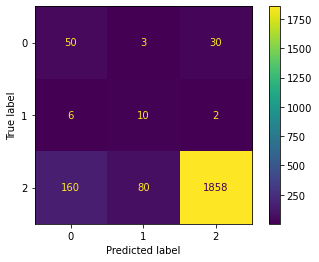

RNN Model:Accuracy of model(<3, = 3, >3) is:   [90.95 95.86 87.63]%
RNN Model:Sensitivity of the test(<3, = 3, >3):[60.24 55.56 88.56]%
RNN Model:Specificity of the test(<3, = 3, >3):[92.16 96.19 68.32]%
RNN Model:Likelihood ratio(<3, = 3, >3):       [ 7.68 14.6   2.8 ]


In [34]:
## plot confusion matrix as well
cm = confusion_matrix(y_true, y_pred)
print(cm)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()
accuracy, sensitivity, specificity, likelihood = contacts_utils.model_stats_all_labels(y_pred, y_true)
print(f'RNN Model:Accuracy of model(<3, = 3, >3) is:   {np.round(accuracy*100, 2)}%')
print(f'RNN Model:Sensitivity of the test(<3, = 3, >3):{np.round(sensitivity*100,2)}%')
print(f'RNN Model:Specificity of the test(<3, = 3, >3):{np.round(specificity*100,2)}%')
print(f'RNN Model:Likelihood ratio(<3, = 3, >3):       {np.round(likelihood, 2)}')

### Plot loss and validation, accuracy errors

In [42]:
#print(history_embedding.history)

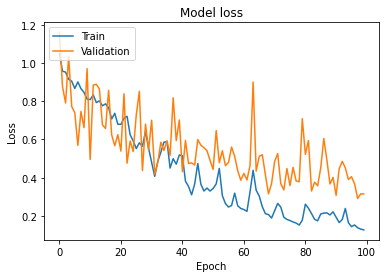

In [36]:
contacts_utils.plot_loss(history_embedding)

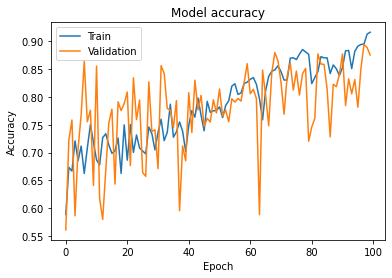

In [37]:
contacts_utils.plot_accuracy(history_embedding)

In [38]:
best_model

### Input test data as shown to determine sentiment based on best RNN model

* Input data also must be pre-processed into tokens before feeding into RNN model

In [39]:
import testdata_prep_rnn as tnn
import pandas as pd
filename = "data/Master-data_Q42021.xlsx"
print(f"Read sheet 'Scrubbed_data' ...")
df_raw = pd.read_excel(filename, sheet_name='Scrubbed_data', index_col='REVIEW_DATE')
# to get a subset as a dataframe, use double bracket notation
some_test_data = df_raw.iloc[:42, :]
some_test_data.columns

tks, wt = tnn.process_test_data(some_test_data, gensim_model)

Read sheet 'Scrubbed_data' ...
Columns dropped: ['OVERALL_RATING', 'COMFORT_RATING', 'VISION_RATING', 'VALUE_FOR_MONEY', 'PROS', 'CONS', 'ORIGINAL_SOURCE', 'REPLY_FROM_ACCUVUE', 'PRODUCT_LINK', 'WEBSITE']
 Drop the Author column and replace it with gender of author ...
Consolidate all the comments into one column called COMMENT
Make ratings into integers
Tokenize data based on regex found from experimentation and common usage ...
Comments before tokenization at index[0]:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!
Comments after tokenization at index[0]:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!
Comments at index[0] before basic cleaning:
 Acucue 2 Contact Lenses I have used these lenses for a lon

In [40]:
tp_raw = best_model.predict(tks)

2/2 [==============================] - 10s 69ms/step


In [41]:
y_test_pred = np.argmax(tp_raw, axis = 1)
y_test_pred

array([0, 2, 2, 2, 2, 0, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0,
       2, 0, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2])